# ANALISIS DE DATOS DE IMÁGENES .fits

## Análisis de los clústers

la idea de este notebook es organizar la información del análisis de los clusters y descargar todo aquello que es redundante, como imágenes y código de prueba que puede encontrarse en el notebook ```Análisis_de_Imagenes.ipynb```

In [1]:
import os
import numpy as np
from scipy import ndimage as ndi
from scipy.stats import poisson
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

from analyfits import misc
from analyfits import manipufits
from analyfits import datafits

import gc

probabilidad = 0.2245

Guardo en lista todo los directorios de las imágenes:

In [2]:
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K"
os.chdir(DIR)
fits_imgs_list = misc.fits_finder(DIR)

###### El procedimiento para reconocer clústers sería el siguiente:
- Me genero el array de numpy que contiene la data de la imagen fits con ```manipufits.ADU2e```.
- Binarizo la imagen usando ```misc.img2bw``` y la guardo en una nueva variable con sufijo ```_bw```. La imagen binarizada es un array de True's y False's. Se pierde la información de intesidades.
- Me armo mis "features labels" usando ```ndi.label``` dándole de comer a esa funcion la imagen binarizada a partir del threshold dado.
- El argumento ```structure``` de ```ndi.label``` define la forma en la que se conectan los features (en mi caso clusters)
- Con ```datafits.get_cluster_info``` (que ya la modifiqué para que me de más propiedades) obtengo la información de los "features" que ndi encontró, en este caso los clusters. El input es el array de numpy con la información de la imagen y los labels que escupe ```ndi.labels```. El output es un diccionario con las siguientes keys: 
    - areas
    - centros
    - coordenadas
    - perimetro
    - energias
    - box
- ploteo la imagen y marco con círculos los clusters que reconoció (opcional - acá no)

Este procedimiento lo voy a aplicar tanto a imagenes originales como a imágenes a las que les voy a agregar ruido sintéticamente utilizando el valor $\mu$ calculado en ```Analisis_imagenes_probabilidad.ipynb``` que es
$\mu = 0.2235 \pm 0.0001$

Voy a trabajar con 3 DataFrames diferentes:
- df_o (df_original) para la información de los clusters detectados en las imágenes originales
- df_l (df_labeled) para la información de los clusters de las imágenes con ruido simulado, usando labels originales
- df_s (df_simulated) para la información de los nuevos clústers al agregar ruido simulado a las imágenes.

Si tengo hechos los archivos, los abro como DataFrames. Si no, empiezo a buscar clusters con el algoritmo en las imagenes originales (puede tardar unos minutos) y los transformo a DataFrames

In [3]:
#=============================================================================
# PARA CARGAR LOS DATOS SIN CORRERLOS CADA VEZ
os.chdir("/media/igna/ignag/Igna/Facultad/Tesis2021/AnalisisImagenesFits/")

# LA CARPETA DONDE TENGO DATOS DE UNA U OTRA CALIBRACIÓN
carpeta = "Data_Calibracion_Nueva"
#carpeta = "Data_Calibracion_Vieja"


# REESCRIBO O NO?
reescribir = False

# Si los archivos existen en el directorio, los cargo
if ("data_original.csv" in os.listdir(carpeta)
    and "data_l_original.csv" in os.listdir(carpeta)
    and "data_sim.csv" in os.listdir(carpeta)
    and reescribir is False):
    os.chdir(carpeta)
    usecols=["img_idx", "energia", "area", "centro", "perimetro"]
    df_o = pd.read_csv("data_original.csv", sep="\t", usecols=usecols)
    df_l = pd.read_csv("data_l_original.csv", sep="\t", usecols=usecols)
    df_s = pd.read_csv("data_sim.csv", sep="\t", usecols=usecols)

# Si no, los genero (pero puede tardar un rato) y armo los DataFrame
elif reescribir is True:
    # ME VOY A LA CARPETA DONDE QUIERO GUARDAR LOS DATOS
    os.chdir(carpeta)
    # datos de las imagenes originales
    lista_dics_o, lista_img_idx_o = datafits.image2cluster_info(fits_imgs_list,
                                                       img="o",
                                                       upp_th=None)
    print("\nListo las originales!\n")
    # datos de imágenes simuladas pero usando los labels de la original
    lista_dics_l, lista_img_idx_l = datafits.image2cluster_info(fits_imgs_list,
                                                       img="l",
                                                       upp_th=None)
    print("\nListo las 'medio' simuladas!\n")
    # datos de imágenes simuladas 100%
    lista_dics_s, lista_img_idx_s = datafits.image2cluster_info(fits_imgs_list,
                                                       img="s",
                                                       upp_th=None)
    print("\nListo las simuladas!\n")
    
    # originales
    df_o = datafits.df_gen(lista_dics_o, lista_img_idx_o)
    df_o.to_csv("data_original.csv", sep="\t")
    # simulados con labels originales
    df_l = datafits.df_gen(lista_dics_l, lista_img_idx_l)
    df_l.to_csv("Data_data_l_original.csv", sep="\t")
    # 100% simulados
    df_s = datafits.df_gen(lista_dics_s, lista_img_idx_s)
    df_s.to_csv("data_sim.csv", sep="\t")
    # Borro lo que ya no me interesa tener
    del (lista_dics_o, lista_img_idx_o, lista_dics_l, lista_img_idx_l,
         lista_dics_s, lista_img_idx_s)
    gc.collect()

In [4]:
# Creo un DataFrame para las diferencias entre originales y medio simuladas\n",
df_diff_ol = df_o.copy()
df_diff_ol["diff_e"] = abs(df_o["energia"] - df_l["energia"])
df_diff_ol["diff_area"] = abs(df_o["area"] - df_l["area"])
df_diff_ol.set_index("img_idx", inplace=True)
#df_diff_ol.drop([\"Unnamed: 0\"], axis=1, inplace=True)\n",
df_diff_ol

,energia,area,centro,perimetro,diff_e,diff_area
img_idx,,,,,,
0.0,2.0,1,"(1.0, 434.0)",0.000000,0.0,0.0
0.0,4.0,2,"(13.0, 68.5)",0.000000,1.0,0.0
0.0,29.0,8,"(16.0, 276.5)",6.000000,8.0,0.0
0.0,8.0,4,"(19.0, 144.25)",3.414214,2.0,0.0
0.0,27.0,3,"(19.666666666666668, 327.6666666666667)",3.414214,25.0,2.0
...,...,...,...,...,...,...
924.0,2.0,1,"(49.0, 289.0)",0.000000,0.0,0.0
924.0,2.0,1,"(49.0, 357.0)",0.000000,0.0,0.0
924.0,4.0,2,"(49.0, 359.5)",0.000000,1.0,0.0


In [5]:
#=============================================================================
# Ahora inteto matchear eventos de mismas imágenes
#
df_diff_os = pd.DataFrame()
Diff_e = pd.DataFrame()
Diff_area = pd.DataFrame()
Diff_perimetro = pd.DataFrame()

index = np.arange(0, 925, 1)

for idx in index:

    df_aux_o = df_o[df_o["img_idx"] == idx]
    df_aux_s = df_s[df_s["img_idx"] == idx]
    
    df_coincidente_o = df_aux_o.loc[df_aux_o["centro"]
                                    .isin(df_aux_s["centro"])].copy()
    df_coincidente_s = df_aux_s.loc[df_aux_s["centro"]
                                    .isin(df_aux_o["centro"])].copy()
    
    df_coincidente_o.reset_index(inplace=True)
    df_coincidente_s.reset_index(inplace=True)
    
    df_coincidente_o.set_index("img_idx", inplace=True)
    df_coincidente_s.set_index("img_idx", inplace=True)
    
    #df_coincidente_o.drop(["Unnamed: 0", "index"], axis=1, inplace=True)
    #df_coincidente_s.drop(["Unnamed: 0", "index"], axis=1, inplace=True)
    
    df_diff_os = df_diff_os.append(df_coincidente_o.copy())
    
    diff_e = df_coincidente_o[["energia"]] - df_coincidente_s[["energia"]]
    diff_area = df_coincidente_o[["area"]] - df_coincidente_s[["area"]]
    diff_perimetro = df_coincidente_o[["perimetro"]] - df_coincidente_s[["perimetro"]]
    
    Diff_e = Diff_e.append(abs(diff_e))
    Diff_area = Diff_area.append(abs(diff_area))
    Diff_perimetro = Diff_perimetro.append(abs(diff_perimetro))
    print("\r%.2f%%" % (idx*100/924), end=" ")

df_diff_os["diff_e"] = Diff_e
df_diff_os["diff_area"] = Diff_area
df_diff_os["diff_perimetro"] = Diff_perimetro
del Diff_e, Diff_area, Diff_perimetro
gc.collect() # Tira la basura que queda en la memoria
df_diff_os

100.00% 

,index,energia,area,centro,perimetro,diff_e,diff_area,diff_perimetro
img_idx,,,,,,,,
0.0,0,2.0,1,"(1.0, 434.0)",0.000000,0.0,0,0.0
0.0,1,4.0,2,"(13.0, 68.5)",0.000000,0.0,0,0.0
0.0,2,29.0,8,"(16.0, 276.5)",6.000000,4.0,0,0.0
0.0,3,8.0,4,"(19.0, 144.25)",3.414214,2.0,0,0.0
0.0,4,27.0,3,"(19.666666666666668, 327.6666666666667)",3.414214,1.0,0,0.0
...,...,...,...,...,...,...,...,...
924.0,462591,2.0,1,"(49.0, 271.0)",0.000000,1.0,0,0.0
924.0,462592,2.0,1,"(49.0, 289.0)",0.000000,0.0,0,0.0
924.0,462593,2.0,1,"(49.0, 357.0)",0.000000,0.0,0,0.0


Por último, tanto a ```df_diff_ol``` y ```df_diff_os``` voy a agregarles dos columnas: 
- Una para la esperanza de la cantidad de carga por cluster (en función del área) para una distribución binomial de la cantidad de eventos por píxel.
- Otra para la esperanza de la cantidad de carga por cluster (en función del área) para una distribución poissoniana de la cantidad de eventos por píxel.

La esperanza de una Binomial viene dada simplemente por 
\begin{equation}
    E(k) = np
\end{equation}

donde $n$ es el número de píxeles y $p$ es la probabilidad de que haya una carga en el píxel.

La esperanza de la Poisson en función de la cantidad de píxeles la calculo de la siguiente manera: Si $\mu$ es la esperanza de la Poissoniana para un dado píxel, entonces si $k$, variable aleatoria con distribución Poissoniana, es el número de electrones espurios por píxel, la esperanza de la variable aleatoria $k$ viene dada por $E(k) = \mu$. Pero para un clúster de $N$ píxeles, el número de electrones espurios por clúster será

$$ n = \sum\limits_{i=1}^{N}k_{i}$$

donde $k_{i}$ es la cantidad de electrones espurios en el píxel $i$-ésimo y $N$ es la cantidad de píxeles del cluster. Entonces, quiero calcular la esperanza de $n$, $E(n)$, y como la esperanza de la suma es la suma de las esperanzas, se tiene

$$E(n) = E\left( \sum\limits_{i=1}^{N} k_{i}\right) = \sum\limits_{i=1}^{N}E(k_{i})$$

como la esperanza de la distribución es la misma, para cualquier $k_{i}$ es el mismo $\mu$, entonces

$$E(n) = \mu \sum\limits_{i=1}^{N} 1 = N \mu,$$

Entonces, la esperanza de la variable aleatoria **número de electrones espurios en un cluster** viene dada por $N\mu$, muy parecida a la binomial.

Como $p$ y $\mu$ son lo mismo, entonces ambas esperanzas son las mismas! Entonces no agrego dos columnas, agrego una sola que se llama esperanza.

In [6]:
df_diff_ol["esperanza"] = df_diff_ol["area"]*probabilidad
df_diff_os["esperanza"] = df_diff_os["area"]*probabilidad

Ya tengo el dataframe con la info que necesito para los clusters con ruido agregado usando labels originales y clusters con ruido agregado usando nuevos labels. El análisis que quiero hacer ahora es, para el rango $160$ a $200$ electrones de carga total (columna ```"energia"```), ver las diferencias y poder estimar el sesgo que agregan al conteo de la carga total de los clusters.

In [7]:
df_diff_ol[(df_diff_ol["energia"]>160) & (df_diff_ol["energia"]<200)]

,energia,area,centro,perimetro,diff_e,diff_area,esperanza
img_idx,,,,,,,
1.0,188.0,8,"(6.75, 20.375)",8.242641,186.0,7.0,1.7960
1.0,192.0,8,"(12.5, 425.875)",7.035534,189.0,7.0,1.7960
1.0,177.0,9,"(27.555555555555557, 327.22222222222223)",8.656854,173.0,7.0,2.0205
1.0,185.0,9,"(39.22222222222222, 322.55555555555554)",7.621320,180.0,7.0,2.0205
1.0,179.0,7,"(48.0, 351.2857142857143)",6.828427,173.0,6.0,1.5715
...,...,...,...,...,...,...,...
923.0,184.0,5,"(46.4, 314.8)",5.207107,131.0,1.0,1.1225
923.0,188.0,8,"(46.875, 345.125)",7.414214,186.0,7.0,1.7960
924.0,175.0,6,"(18.5, 281.3333333333333)",6.414214,172.0,5.0,1.3470


In [8]:
df_diff_os[(df_diff_os["energia"]>160) & (df_diff_os["energia"]<200)]

,index,energia,area,centro,perimetro,diff_e,diff_area,diff_perimetro,esperanza
img_idx,,,,,,,,,
1.0,67,188.0,8,"(6.75, 20.375)",8.242641,0.0,0,0.0,1.7960
1.0,554,185.0,9,"(39.22222222222222, 322.55555555555554)",7.621320,0.0,0,0.0,2.0205
2.0,820,182.0,6,"(4.833333333333333, 416.1666666666667)",6.242641,1.0,0,0.0,1.3470
2.0,905,169.0,7,"(9.285714285714286, 391.0)",6.828427,0.0,0,0.0,1.5715
2.0,1162,161.0,7,"(27.285714285714285, 10.571428571428571)",7.207107,1.0,0,0.0,1.5715
...,...,...,...,...,...,...,...,...,...
923.0,462002,181.0,4,"(45.75, 272.75)",3.207107,1.0,0,0.0,0.8980
923.0,462016,188.0,8,"(46.875, 345.125)",7.414214,1.0,0,0.0,1.7960
924.0,462203,175.0,6,"(18.5, 281.3333333333333)",6.414214,1.0,0,0.0,1.3470


## Histogramas de carga para cada dataset
#### original
#### simulado y labels originales
#### simulado 100%

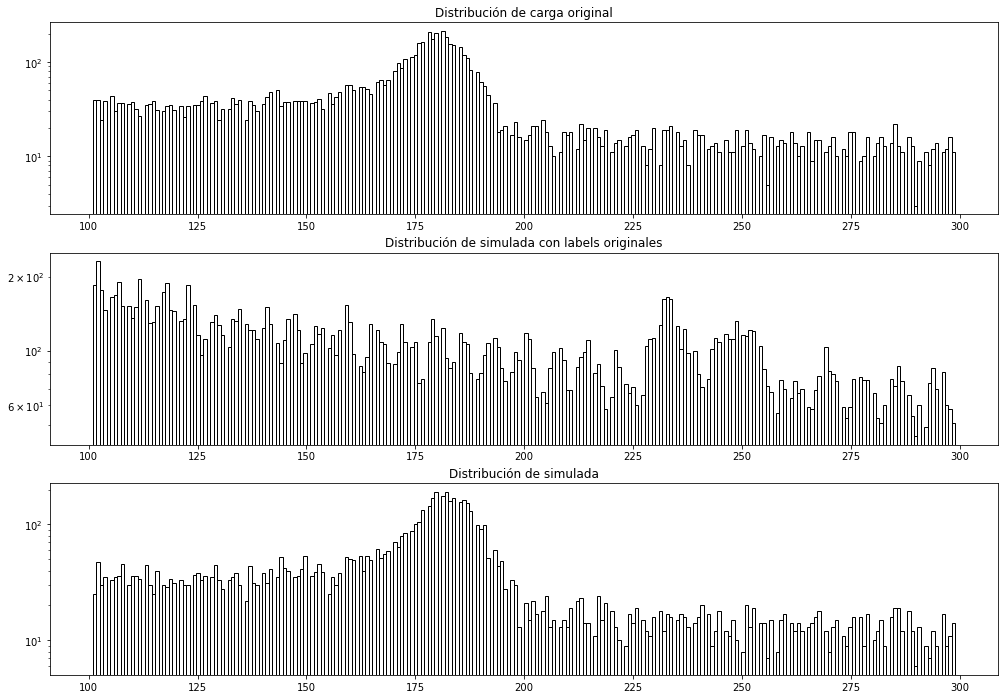

In [9]:
energia_o = df_o[(df_o["energia"]>100) & (df_o["energia"]<300)]["energia"]
energia_l = df_l[(df_l["energia"]>100) & (df_l["energia"]<300)]["energia"]
energia_s = df_s[(df_s["energia"]>100) & (df_s["energia"]<300)]["energia"]

fig, axs = plt.subplots(3,1, figsize=(17,12))

axs[0].set_title("Distribución de carga original")
axs[0].hist(energia_o, bins=250, fill=False)
axs[0].set_yscale("log")
axs[1].set_title("Distribución de simulada con labels originales")
axs[1].hist(energia_l, bins=250, fill=False)
axs[1].set_yscale("log")
axs[2].set_title("Distribución de simulada")
axs[2].hist(energia_s, bins=250, fill=False);
axs[2].set_yscale("log")

## Comparación entre datos medidos, simulaciones y teórico
### Caso simulado con labels originales

In [10]:
# =============================================================================
# nuevo DataFrame
DF_ol = df_diff_ol[["area", "diff_e", "esperanza"]].groupby("area").mean()
DF_ol["error"] = df_diff_ol[["area", "diff_e"]].groupby("area").std()
# reseteo el índice 
DF_ol.reset_index(inplace=True)

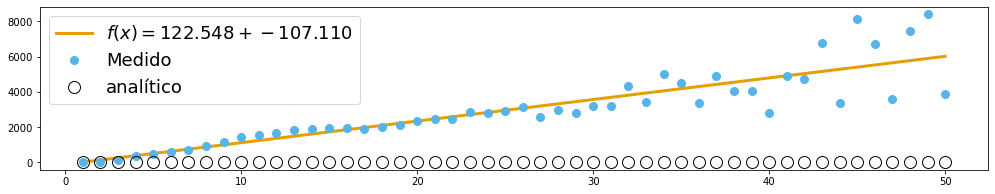

In [11]:
# Hago el ajuste
m, b = misc.regresion_lineal(DF_ol["area"].head(50), DF_ol["diff_e"].head(50))


plt.figure(figsize=(17, 3))
# ploteo el ajuste
plt.plot(DF_ol["area"].head(50), DF_ol["area"].head(50)*m + b, 
         color="#E69F00",
         linewidth=3,label="$f(x)=%.3f + %.3f$" % (m, b))

# ploteo los datos promediados
plt.plot(DF_ol["area"].head(50), DF_ol["diff_e"].head(50),
         'o',
         color="#56B4E9", 
         markersize=8,
         label="Medido")

# ploteo la teórica (binomial) con circulos abiertos
plt.plot(DF_ol["area"].head(50), DF_ol["esperanza"].head(50),
         'o',
         color="k",
         markersize=12,
         fillstyle="none",
         label="analítico")
plt.legend(fontsize=18);
#plt.savefig("BinomialVSMontecarlo.pdf")

### Caso 100% simulado

In [12]:
# =============================================================================
# nuevo DataFrame
DF_os = df_diff_os[["area", "diff_e", "esperanza"]].groupby("area").mean()
DF_os["error"] = df_diff_os[["area", "diff_e"]].groupby("area").std()
# reseteo el índice 
DF_os.reset_index(inplace=True)

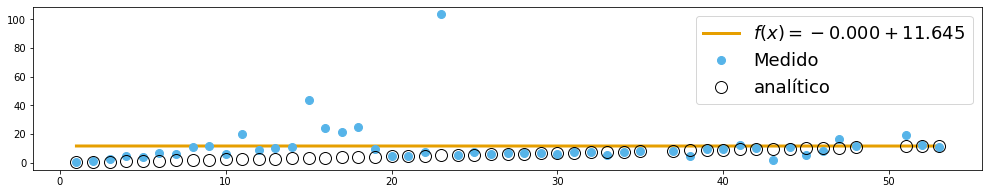

In [13]:
# Hago el ajuste
m, b = misc.regresion_lineal(DF_os["area"].head(50), DF_os["diff_e"].head(50))


plt.figure(figsize=(17, 3))
# ploteo el ajuste
plt.plot(DF_os["area"].head(50), DF_os["area"].head(50)*m + b, 
         color="#E69F00",
         linewidth=3,label="$f(x)=%.3f + %.3f$" % (m, b))

# ploteo los datos promediados
plt.plot(DF_os["area"].head(50), DF_os["diff_e"].head(50),
         'o',
         color="#56B4E9", 
         markersize=8,
         label="Medido")

# ploteo la teórica (binomial) con circulos abiertos
plt.plot(DF_os["area"].head(50), DF_os["esperanza"].head(50),
         'o',
         color="k",
         markersize=12,
         fillstyle="none",
         label="analítico")
plt.legend(fontsize=18);
#plt.savefig("BinomialVSMontecarlo.pdf")

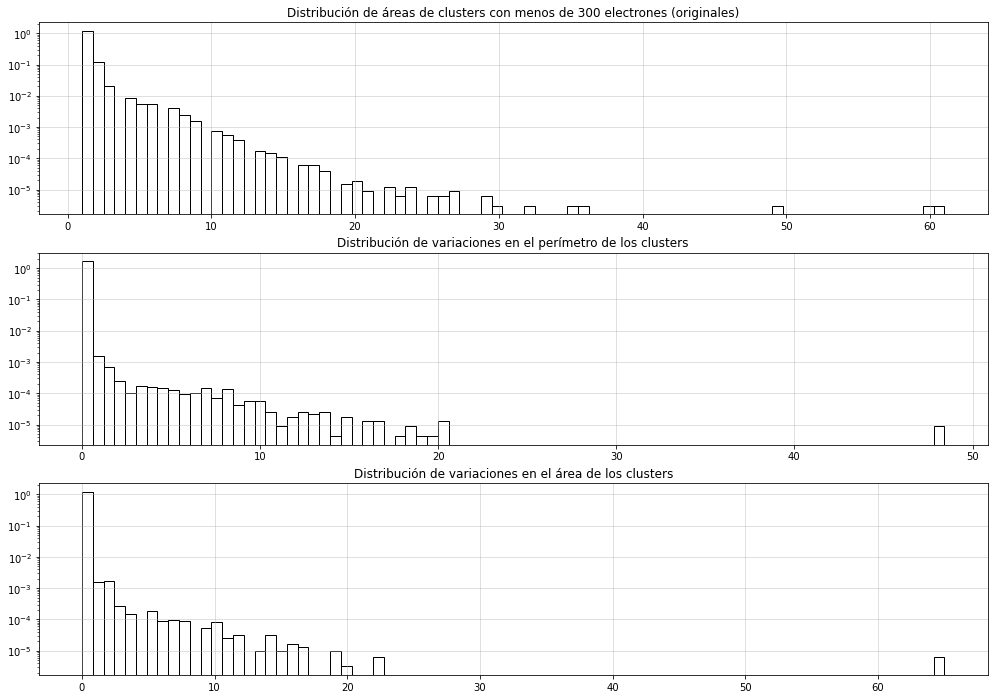

In [14]:
fig, axs = plt.subplots(3,1, figsize=(17,12))

axs[0].set_title("Distribución de áreas de clusters con menos de 300 electrones (originales)")
axs[0].hist(df_o[df_o["energia"]<250]["area"], bins=80, density=True, fill=False)
axs[0].set_yscale("log")
axs[0].grid(alpha=.5)

axs[1].set_title("Distribución de variaciones en el perímetro de los clusters")
axs[1].hist(df_diff_os["diff_perimetro"], bins=80, density=True, fill=False)
axs[1].set_yscale("log")
axs[1].grid(alpha=.5)


axs[2].set_title("Distribución de variaciones en el área de los clusters")
axs[2].hist(df_diff_os["diff_area"], bins=80, density=True, fill=False)
axs[2].set_yscale("log")
axs[2].grid(alpha=.5)


In [15]:
# Promedio de eventos entre 160 y 220 por imagen
eventosF_p_img = len(df_o[(df_o["energia"]>160) & (df_o["energia"]<220)])/925
eventosF_tot = len(df_o[(df_o["energia"]>160) & (df_o["energia"]<220)])

In [16]:
# Promedio de eventos entre 1400 y 1600 por imagen
eventosFE_p_img = len(df_o[(df_o["energia"]>1400) & (df_o["energia"]<1600)])/925
eventosFE_tot = len(df_o[(df_o["energia"]>1400) & (df_o["energia"]<1600)])

In [17]:
print(f"eventos de F totales: {eventosF_tot}")
print(f"eventos de F por imagen: {eventosF_p_img:.2f}")
print(f"eventos de Fe totales: {eventosFE_tot}")
print(f"eventos de Fe por imagen: {eventosFE_p_img:.2f}")

eventos de F totales: 3900
eventos de F por imagen: 4.22
eventos de Fe totales: 2067
eventos de Fe por imagen: 2.23


In [18]:
df_o

,img_idx,energia,area,centro,perimetro
0,0.0,2.0,1,"(1.0, 434.0)",0.000000
1,0.0,4.0,2,"(13.0, 68.5)",0.000000
2,0.0,29.0,8,"(16.0, 276.5)",6.000000
3,0.0,8.0,4,"(19.0, 144.25)",3.414214
4,0.0,27.0,3,"(19.666666666666668, 327.6666666666667)",3.414214
...,...,...,...,...,...
462592,924.0,2.0,1,"(49.0, 289.0)",0.000000
462593,924.0,2.0,1,"(49.0, 357.0)",0.000000
462594,924.0,4.0,2,"(49.0, 359.5)",0.000000
462595,924.0,5.0,1,"(49.0, 419.0)",0.000000
